# Insert worm

In [497]:
import numpy as np
import bisect
import matplotlib.pyplot as plt
import pimc # custom module
from scipy.stats import truncexpon
from scipy.integrate import quad, simps
import importlib
importlib.reload(pimc)

<module 'pimc' from '/Users/ecasiano/Desktop/LatticePIMC/src/pimc.py'>

### Simulation parameters

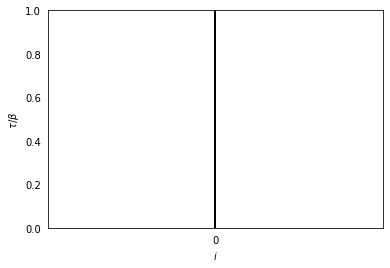

In [536]:
importlib.reload(pimc)
# Simulation parameters
t = 0
U = 1
mu = 0.1
    
# PIMC parameters
beta = 1
eta = 1      # worm end fugacity

# Canonical or Grand Canonical?
canonical = False

# Create a worldline configuration
L = 1
N = 2
alpha = []
for i in range(L):
    alpha.append(N)
data_struct = pimc.create_data_struct(alpha)
head_loc = []
tail_loc = []
pimc.view_worldlines(data_struct,beta,figure_name=None)

### Do many inserts

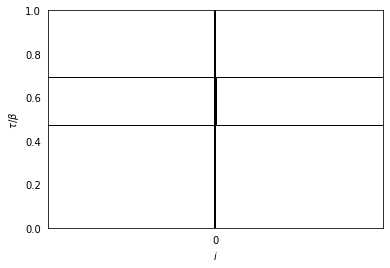

In [537]:
importlib.reload(pimc)
# Do insert many times on the above configuration
mc_steps = int(1E+04)
worm_lengths = np.zeros(mc_steps)  # create array to save worm lengths
need_dV = True # Flag to see if dV has been calculated alrady or not 

for m in range(mc_steps):

    pimc.worm_insert(data_struct, beta, head_loc, tail_loc, U, mu, eta,
                   canonical, N)
 
    # Don't collect wormlength data if no insertion was done
    if head_loc == [] or tail_loc == []: continue
    
    # Calculate change in diagonal energy after/before worm end (need this for scale)
    if need_dV:
        n_f = data_struct[tail_loc[0]][tail_loc[1]][1]   
        n_o = data_struct[head_loc[0]][head_loc[1]][1] 
        dV = (U/2)*(n_f*(n_f-1)-n_o*(n_o-1)) - mu*(n_f-n_o)
        need_dV = False
        
    # Times of head and tail
    tau_h = data_struct[head_loc[0]][head_loc[1]][0]
    tau_t = data_struct[tail_loc[0]][tail_loc[1]][0]
    
    worm_lengths[m] = tau_h-tau_t
    is_worm = True
    if worm_lengths[m] < 0: # antiworm correction
        worm_lengths[m] += beta
        is_worm = False
    
    if m == mc_steps - 1: break
        
    # Create a worldline configuration
    alpha = []
    for i in range(L):
        alpha.append(N)
    data_struct = pimc.create_data_struct(alpha)
    head_loc = []
    tail_loc = []
    
pimc.view_worldlines(data_struct,beta,figure_name=None)

In [538]:
# Histogram of worm lengths
b = beta
loc = 0

if dV == 0:
    dV = np.finfo(float).eps # machine epsilon
scale = 1/abs(dV)

# Generate truncated exponential distribution of worm lengths
tau_w = np.linspace(0,beta,int(1E+02+1))                    # worm lengths
tau_w = (tau_w[1:]+tau_w[0:-1])/2    
#[time,N,(src,dest)]

# Theoretical distribution of lenghths (worm and antiworm)
pdf = truncexpon.pdf(tau_w,b=b/scale,loc=loc,scale=scale)
if (dV < 0):
    pdf = truncexpon.pdf(-tau_w+b,b=b/scale,loc=loc,scale=scale)

pdf /= simps(pdf,tau_w)

# Sampled worm lengths
n, bins = np.histogram(worm_lengths, bins=tau_w, density=1) # for histogram

dV:  1.9


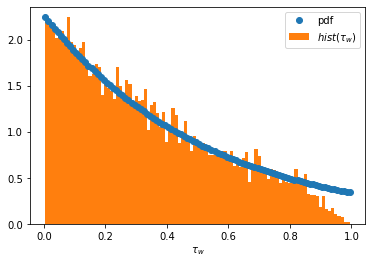

In [539]:
# Plot
fig, ax = plt.subplots(1, 1)
ax.plot(tau_w,pdf,label='pdf',linestyle='None',marker='o')
ax.hist(worm_lengths,bins=bins,density=True,histtype='stepfilled',alpha=1,label=r'$hist(\tau_w)$')
ax.set_xlabel(r"$\tau_w$") ;
#ax.set_yscale("log");
plt.legend() ;
print("dV: ",dV)
plt.savefig("insert_%d_%d_%.4f_%.4f_%.4f_%.4f_%d_worm.pdf"%(L,N,U,mu,t,eta,mc_steps))

In [540]:
# Histogram of tau_w (WORM LENGTH, not antiworm)

# Move: Insert

# Insert worm
    # dV < 0: increasing truncexpon
    # dV == 0: flat distribution
    # dV > 0: decreasing truncexpon
    
# Insert antiworm
#     dV < 0: increasing truncexpon
#     dV == 0: flat distribution
#     dV > 0: decreasing truncexpon

# NOTE: THE PLOTS WERE DONE AT FIXED R=1